# Overview of collected data
This notebook provides an overview of the data collected by SWIFT buoys. The wavespectra and significant wave height are plotted together with co-located sea ice concentration and local ice condition from SWIFT onboard imagery.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import rc
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import ScalarFormatter

from plots import plot_panel, nice_time_axis, mark_time_range, subplot_time_grid, icetype_colorbar, icegroup_colorbar
rc('font', size=20)

In [2]:
def remove_bad_airtemp(swift):
    # Remove bad temperature data
    standard_deviation_threshold = 2 # degree Celcius
    swift.loc[swift.airtempstddev > standard_deviation_threshold, 'airtemp'] = np.nan

def plot_spectra(swift, timestamp_str, *args, ax = None, **kwargs):      
    if ax is None:
        ax = plt.gca()
    
    # find correct row
    desired_timestamp = np.datetime64(timestamp_str)
    i = abs(swift['timestamp'] - desired_timestamp).idxmin()
    
    # plot
    if abs(swift['timestamp'].iloc[i] - desired_timestamp) < pd.Timedelta(hours=1):
        plt.plot(swift.iloc[i]['wavespectra.freq'], swift.iloc[i]['wavespectra.energy'], *args, **kwargs)
    else:
        raise ValueError('The desired timestamp does not exist')
        
def mark_frequency_range(f_range, ax = None):
    # Based on https://stackoverflow.com/a/31163913/11028793
    from matplotlib.patches import Rectangle
    if ax is None:
        ax = plt.gca()
    
    # Rectangle x coordinates
    width = f_range[1] - f_range[0]
    
    # Rectangle y coordinates
    ylim = ax.get_ylim()
    height = ylim[1] - ylim[0]
    
    # Plot rectangle
    rect = Rectangle((f_range[0], ylim[0]), width, height, zorder=-2, color='lavender')
    ax.add_patch(rect)
    
def plot_cross(df, label, x_col, y_col, x_factor = 1, y_factor = 1, **kwargs):
    x_percentiles = np.nanpercentile(df[x_col], [25,50,75])*x_factor
    y_percentiles = np.nanpercentile(df[y_col], [25,50,75])*y_factor

    plt.errorbar(x_percentiles[1], 
                 y_percentiles[1],
                 xerr = np.array([abs(x_percentiles[[0,2]]-x_percentiles[1])]).T,
                 yerr = np.array([abs(y_percentiles[[0,2]]-y_percentiles[1])]).T,
                 fmt = '.',
                 label=label, 
                 **kwargs)

In [3]:
swift20_winter = pd.read_feather('../processed_data/swift20_winter.feather')
swift21_winter = pd.read_feather('../processed_data/swift21_winter.feather')
swift20_spring = pd.read_feather('../processed_data/swift20_spring.feather')
swift21_spring = pd.read_feather('../processed_data/swift21_spring.feather')

In [4]:
remove_bad_airtemp(swift20_winter)
remove_bad_airtemp(swift21_winter)
remove_bad_airtemp(swift20_spring)
remove_bad_airtemp(swift21_spring)

/home/stina/projects/roammiz-wave-seaice-interactions/src/plots.py:230: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


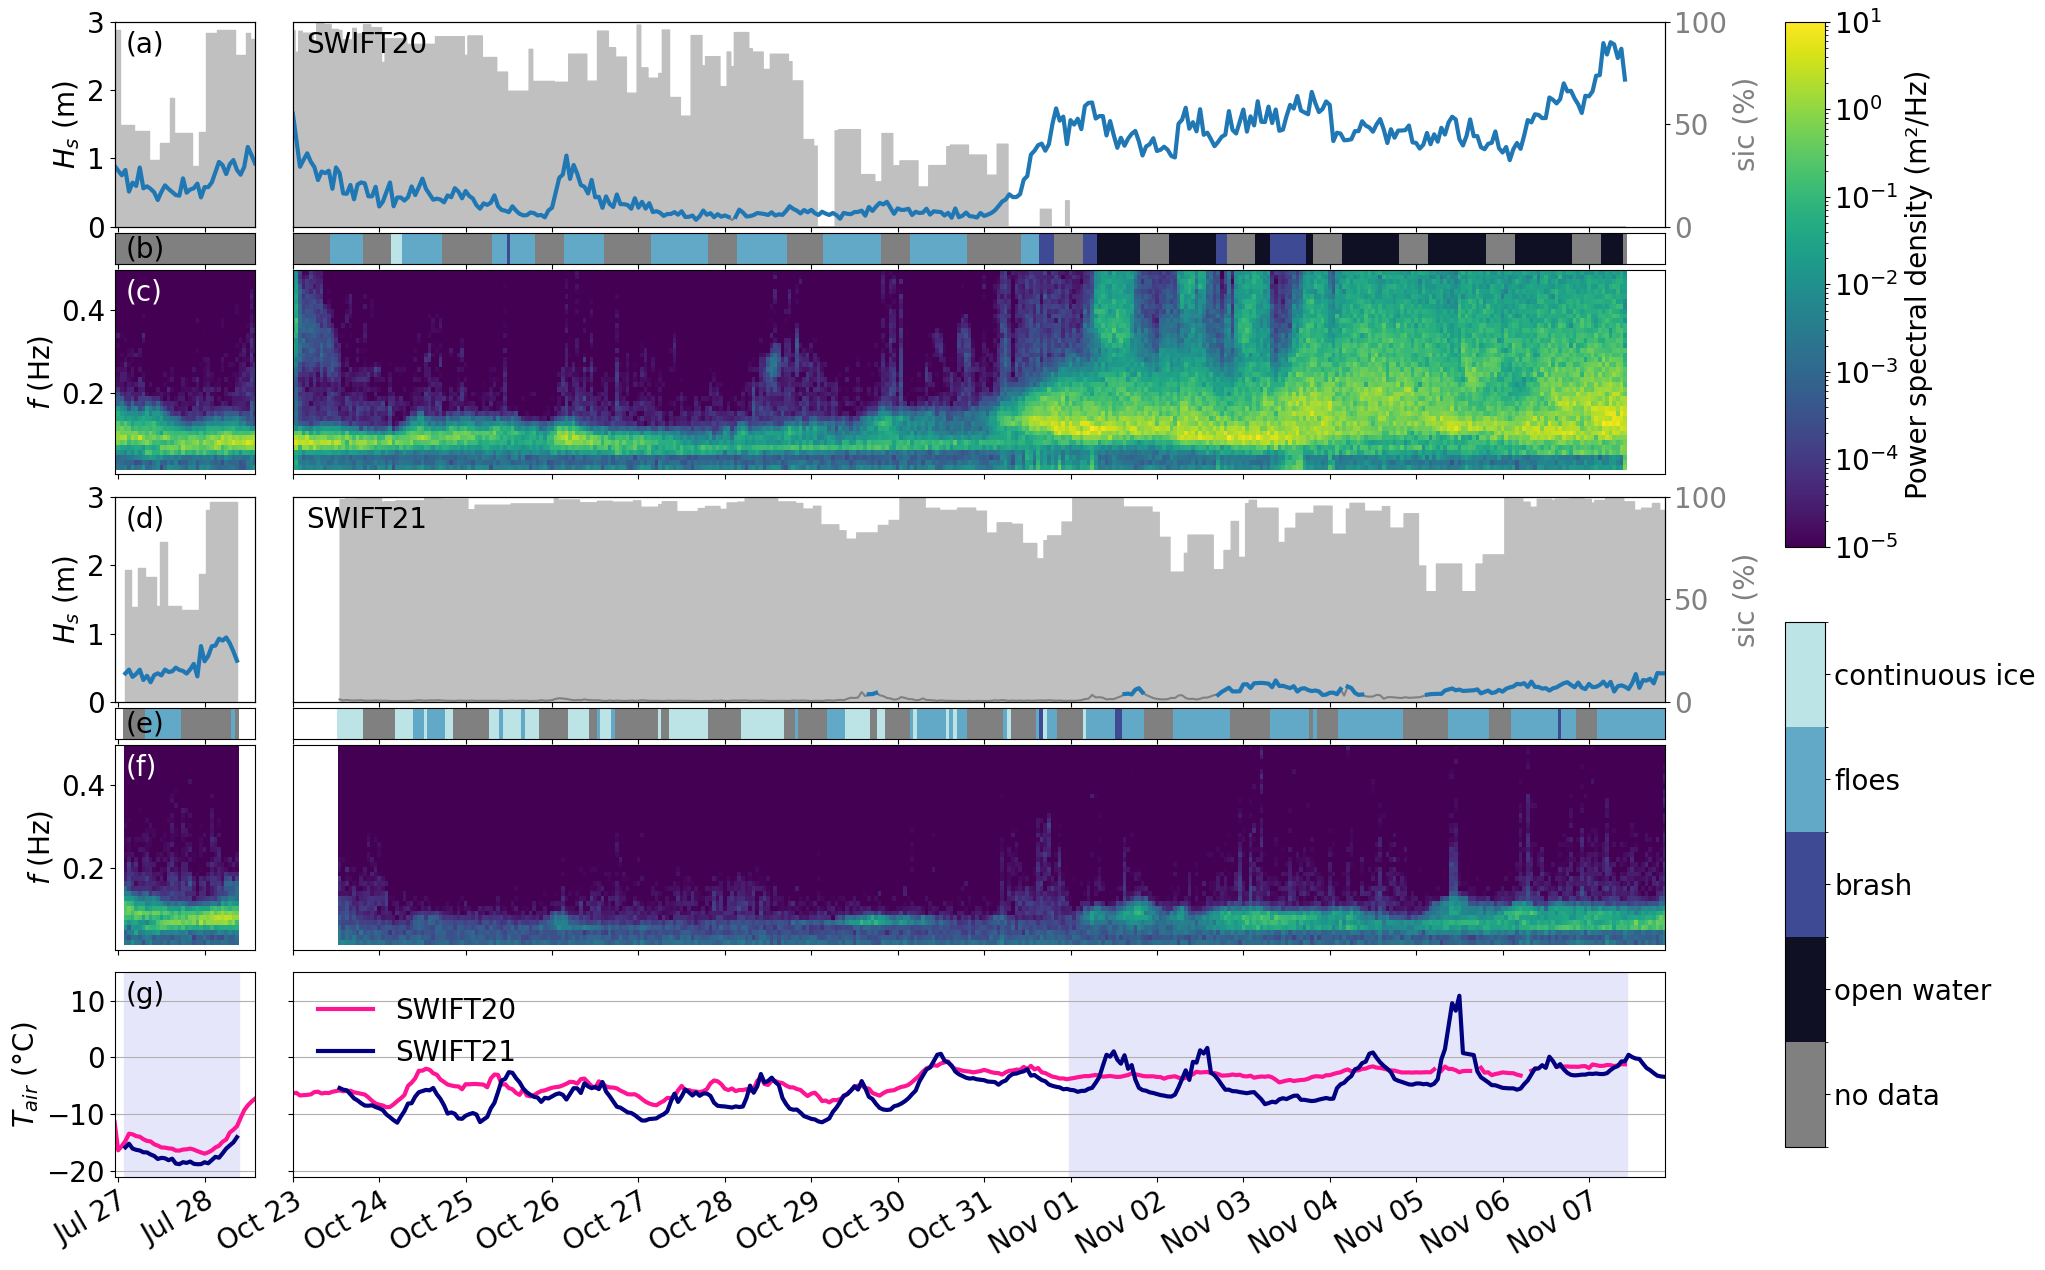

In [5]:
separation = 0.05 
fig, ax = subplot_time_grid([swift20_winter, swift20_spring, swift21_winter, swift21_spring], 9, 2 , 
                             sharey = False,
                             height_ratios = [1,0.15,1, separation, 1,0.15,1, separation, 1],
                             hspace = 0.05, wspace = 0.05,
                            )
group_ice_code = True # Show fewer ice type catergories
fig.set_size_inches(20, 15)

vmin = 1e-5
vmax = 10
wave_height_ylim = [0, 3]



plot_panel(swift20_winter, ax[0:6:2], vmin, vmax, y_right_visible = False, wave_height_ylim = wave_height_ylim, group_ice = group_ice_code)
plot_panel(swift20_spring, ax[1:7:2], vmin, vmax, y_left_visible = False, wave_height_ylim = wave_height_ylim, group_ice = group_ice_code)
plot_panel(swift21_winter, ax[8:14:2], vmin, vmax, y_right_visible = False, wave_height_ylim = wave_height_ylim, group_ice = group_ice_code)
plot_panel(swift21_spring, ax[9:15:2], vmin, vmax, y_left_visible = False, wave_height_ylim = wave_height_ylim, group_ice = group_ice_code)

# Air temperature
T_lim = [-21,15]
linewidth = 3
swift20_color = 'deeppink'
swift21_color = 'navy'
ax[16].plot(swift20_winter['timestamp'],swift20_winter['airtemp'], linewidth=linewidth, color=swift20_color)
ax[16].plot(swift21_winter['timestamp'],swift21_winter['airtemp'], linewidth=linewidth, color=swift21_color)
ax[17].plot(swift20_spring['timestamp'],swift20_spring['airtemp'], linewidth=linewidth, color=swift20_color, label='SWIFT20')
ax[17].plot(swift21_spring['timestamp'],swift21_spring['airtemp'], linewidth=linewidth, color=swift21_color, label='SWIFT21')
ax[16].set_ylim(T_lim)
ax[17].set_ylim(T_lim)
ax[16].set_yticks(ticks=[-20,-10,0,10])
ax[17].set_yticks(ticks=[-20,-10,0,10])
ax[16].grid(axis = 'y')
ax[17].grid(axis = 'y')
ax[17].legend(loc = 'upper left', frameon=False)
ax[17].set_yticklabels([])
ax[16].set_ylabel('$T_{air}$ (°C)')

# Mark time range used when deriving attenuation
time_range_winter = [np.datetime64('2019-07-27 01:30'), np.datetime64('2019-07-28 09:30')]
mark_time_range(time_range_winter, ax = ax[16])
time_range_spring = [np.datetime64('2019-10-31 23:30'), np.datetime64('2019-11-07 10:30')]
mark_time_range(time_range_spring, ax = ax[17])

# Create distance between buoys by adding a panel
ax[6].axis('off')
ax[7].axis('off')
ax[14].axis('off')
ax[15].axis('off')

# Nicer x-axis
nice_time_axis(ax[16])
nice_time_axis(ax[17])

# Annotation
pos = (0.08, 0.85)
ax[0].annotate('(a)', xy=pos, xycoords='axes fraction')
ax[2].annotate('(b)', xy=(0.08,0.2), xycoords='axes fraction')
ax[4].annotate('(c)', xy=pos, xycoords='axes fraction', color='white')
ax[8].annotate('(d)', xy=pos, xycoords='axes fraction')
ax[10].annotate('(e)', xy=(0.08,0.2), xycoords='axes fraction')
ax[12].annotate('(f)', xy=pos, xycoords='axes fraction', color='white')
ax[16].annotate('(g)', xy=pos, xycoords='axes fraction')
ax[1].annotate('SWIFT20', xy=(0.01, 0.85), xycoords='axes fraction')
ax[9].annotate('SWIFT21', xy=(0.01, 0.85), xycoords='axes fraction')

# Add colorbars
fig.subplots_adjust(right=0.9)
cbar_ax_spectra = fig.add_axes([0.96, 0.53, 0.02, 0.35])
fig.colorbar(plt.cm.ScalarMappable(norm = LogNorm(vmin, vmax)),
             cax = cbar_ax_spectra,
             label = 'Power spectral density (m²/Hz)')

cbar_ax_ice = fig.add_axes([0.96, 0.13, 0.02, 0.35])

if group_ice_code:
    icegroup_colorbar(cax=cbar_ax_ice, labelpad=-25)
else:
    icetype_colorbar(cax=cbar_ax_ice, label = 'Ice code', labelpad=-25)

plt.savefig('../figures/data_overview.png', dpi=300, bbox_inches='tight')
plt.show()

In [6]:
deployments = [swift20_winter, 
               swift21_winter,
               swift20_spring.loc[swift20_spring.sic<15],
               swift20_spring.loc[swift20_spring.sic>=15], 
               swift21_spring[swift21_spring.sigwaveheight >=0.1],
               swift21_spring[swift21_spring.sigwaveheight < 0.1]]
labels      = ['winter SWIFT20',
               'winter SWIFT21',
               'spring open water',
               'spring SWIFT20',
               'spring SWIFT21',
               'spring no wave activity']
colors      = ['orchid',
               'lightskyblue',
               'black',
               'deeppink',
               'royalblue',
               'gray']

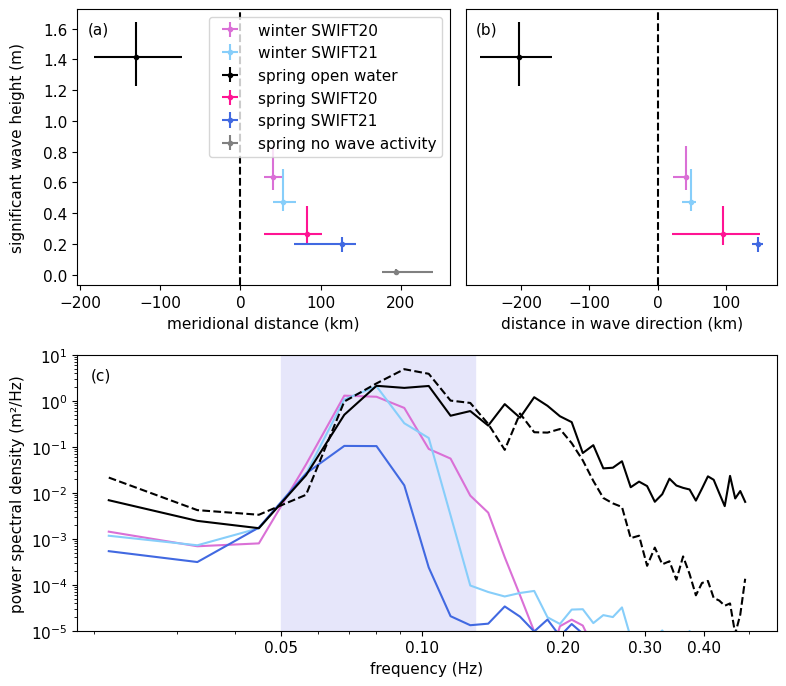

In [7]:
rc('font', size=11)
fig = plt.figure(figsize=(8,7), tight_layout=True)
gs  = GridSpec(2, 2, height_ratios = (1,1), width_ratios = (1.2,1))

ax1 = fig.add_subplot(gs[0, 0])
plt.sca(ax1)
for (df,label,color) in zip(deployments, labels, colors):
    plot_cross(df, label, "dist_meridian", "sigwaveheight", x_factor=1e-3, color=color)
plt.xlabel('meridional distance (km)')
plt.ylabel('significant wave height (m)')
plt.legend(loc='upper right')

ax2 = fig.add_subplot(gs[0, 1])
plt.sca(ax2)
for (df,label,color) in zip(deployments[:-1], labels[:-1], colors[:-1]):
    plot_cross(df, label, "dist_wavedir", "sigwaveheight", x_factor=1e-3, color = color)
plt.xlabel('distance in wave direction (km)')
ax2.get_yaxis().set_visible(False)

# Add ice edge
ylim = ax1.get_ylim()
#ylim = (0, ylim[1])
ax1.plot([0,0], ylim, '--k')
ax2.plot([0,0], ylim, '--k')
ax1.set_ylim(ylim)
ax2.set_ylim(ylim)

# Example spectra
ax3 = fig.add_subplot(gs[1, :])
plot_spectra(swift20_winter, '2019-07-28 03:00', ax=ax3, color = colors[0])
plot_spectra(swift21_winter, '2019-07-28 03:00', ax=ax3, color = colors[1])
plot_spectra(swift21_spring, '2019-11-03 12:00', ax=ax3, color = colors[4])
plot_spectra(swift20_spring, '2019-11-03 06:00', ax=ax3, color = colors[2])
plot_spectra(swift20_spring, '2019-11-03 09:00', ax=ax3, color = colors[2], linestyle = 'dashed')

plt.xscale('log')
plt.yscale('log')
plt.ylabel('power spectral density (m²/Hz)')
plt.xlabel('frequency (Hz)')
mark_frequency_range((0.05,0.13))
plt.ylim([1e-5,10])

ax3.get_xaxis().set_major_formatter(ScalarFormatter())
ax3.set_xticks([0.05, 0.1,0.2,0.3,0.4,])

fig.align_labels()

# Annotations
ax1.annotate('(a)', xy=(0.03, 0.91), xycoords='axes fraction')
ax2.annotate('(b)', xy=(0.03, 0.91), xycoords='axes fraction')
ax3.annotate('(c)', xy=(0.02, 0.91), xycoords='axes fraction')

plt.savefig('../figures/wave_overview.png', dpi=300, bbox_inches='tight')

plt.show()